In [23]:
import pandas as pd 
import tensorflow as tf
import numpy as np

In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
url = 'http://hilpisch.com/aiif_eikon_id_eur_usd.csv'
symbol='EUR_USD'
raw = pd.read_csv(url,index_col=0,parse_dates=True)



In [3]:
raw.head()

,HIGH,LOW,OPEN,CLOSE
Date,,,,
2019-10-01 00:00:00,1.0899,1.0897,1.0897,1.0899
2019-10-01 00:01:00,1.0899,1.0896,1.0899,1.0898
2019-10-01 00:02:00,1.0898,1.0896,1.0898,1.0896
2019-10-01 00:03:00,1.0898,1.0896,1.0897,1.0898
2019-10-01 00:04:00,1.0898,1.0896,1.0897,1.0898


In [5]:
raw.shape

(96526, 4)

In [4]:
def generate_data():
  data = pd.DataFrame(raw['CLOSE'])
  data.columns=[symbol]
  data = data.resample('30min',label='right').last().ffill()
  return data 

In [6]:
data = generate_data()

In [7]:
data

,EUR_USD
Date,
2019-10-01 00:30:00,1.0899
2019-10-01 01:00:00,1.0896
2019-10-01 01:30:00,1.0892
2019-10-01 02:00:00,1.0890
2019-10-01 02:30:00,1.0886
...,...
2019-12-31 21:30:00,1.1212
2019-12-31 22:00:00,1.1208
2019-12-31 22:30:00,1.1211


In [8]:
data = (data-data.mean())/data.std()
p = data[symbol].values
p = p.reshape((len(p),-1))

In [14]:
lags = 5
g = tf.keras.preprocessing.sequence.TimeseriesGenerator(p,p,length=lags,batch_size=5)


In [17]:
from keras.models import Sequential
from keras.layers import SimpleRNN ,Dense,LSTM

In [18]:
def create_rnn_model(hu=100,lags=lags,layer='SimpleRNN',features=1,algorithm='estimation'):
  model=Sequential()
  if layer is 'SimpleRNN':
    model.add(SimpleRNN(hu,activation='relu',input_shape=(lags,features)))

  else:
    model.add(LSTM(hu,activation='relu',input_shape=(lags,features)))
  
  if algorithm == 'estimation':
    model.add(Dense(1,activation='linear'))
    model.compile(optimizer='adam',loss='mse',metrics=['mae'])

  else:
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

  return model

  

<>:3: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:3: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
/var/folders/9r/pg_gv8jd0yj_gzqlzl5t2n040000gn/T/ipykernel_75031/2193453398.py:3: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  if layer is 'SimpleRNN':


In [19]:
model = create_rnn_model()

/Users/baijuyadav/Desktop/deeplearningfromscratch/deeplearningscratch/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
%%time
model.fit(g,epochs=500,steps_per_epoch=10,verbose=False)

/Users/baijuyadav/Desktop/deeplearningfromscratch/deeplearningscratch/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


CPU times: user 5.46 s, sys: 441 ms, total: 5.9 s
Wall time: 4.42 s


/var/folders/9r/pg_gv8jd0yj_gzqlzl5t2n040000gn/T/ipykernel_75031/3135003819.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['pred'].iloc[lags:] = y.flatten()


<Axes: xlabel='Date'>

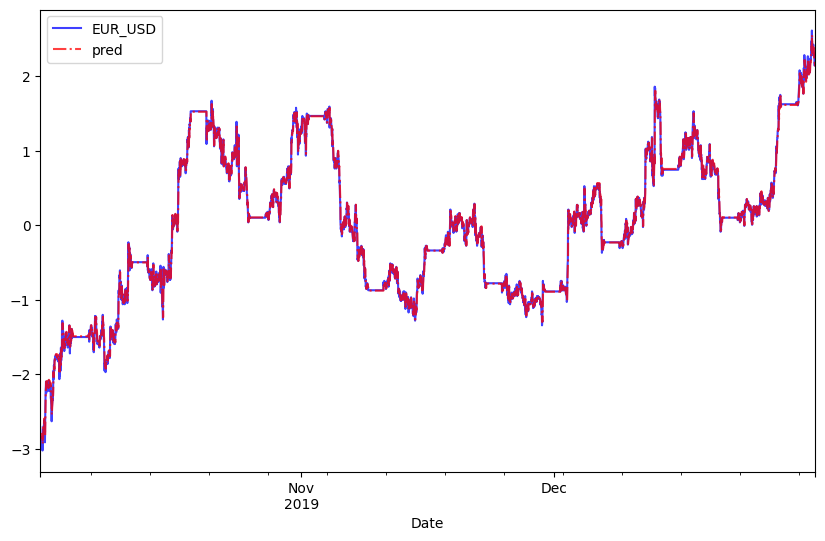

In [24]:
y = model.predict(g,verbose=False)
data['pred']=np.nan
data['pred'].iloc[lags:] = y.flatten()
data[[symbol,'pred']].plot(figsize=(10,6),style=['b','r-.'],alpha=0.75)

<Axes: xlabel='Date'>

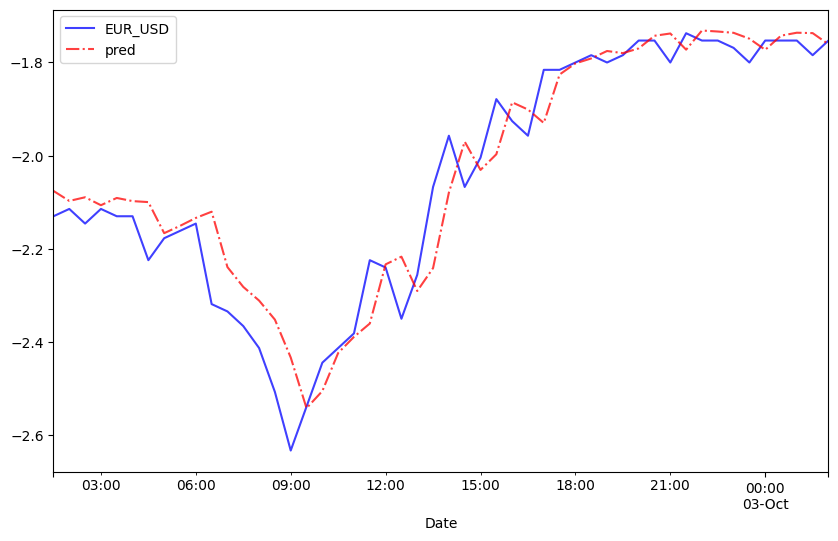

In [25]:
data[[symbol,'pred']].iloc[50:100].plot(figsize=(10,6),style=['b','r-.'],alpha=0.75)